In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import mplfinance as mpf
import matplotlib.pyplot as plt
import os
import random
import copy
import time
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim


### Loading Commodities data

In [3]:
# Crude Oil : CL=F
# Natural Gas : NG=F
# Gold : GC=F
# Silver : SI=F
# Copper : HG=F
# S&P 500 : ^GSPC
# Dow Jones : ^DJI

ticker = "CL=F"
start = "2023-01-01"
end = "2024-01-01"
interval = "1d"

data = yf.download(ticker, start=start, end=end, interval=interval)
data.columns = data.columns.droplevel(1)  

date_split = "2024-09-01"
data_train = data.loc[:date_split]
data_test = data.loc[date_split:]

print(data.head())
print(data_test.head())



YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open  Volume
Date                                                          
2023-01-03  76.930000  81.500000  76.599998  80.570000  338520
2023-01-04  72.839996  77.419998  72.730003  77.250000  352434
2023-01-05  73.669998  74.919998  72.459999  73.250000  300731
2023-01-06  73.769997  75.470001  73.239998  73.970001  258128
2023-01-09  74.629997  76.739998  73.470001  73.470001  329290
Empty DataFrame
Columns: [Close, High, Low, Open, Volume]
Index: []


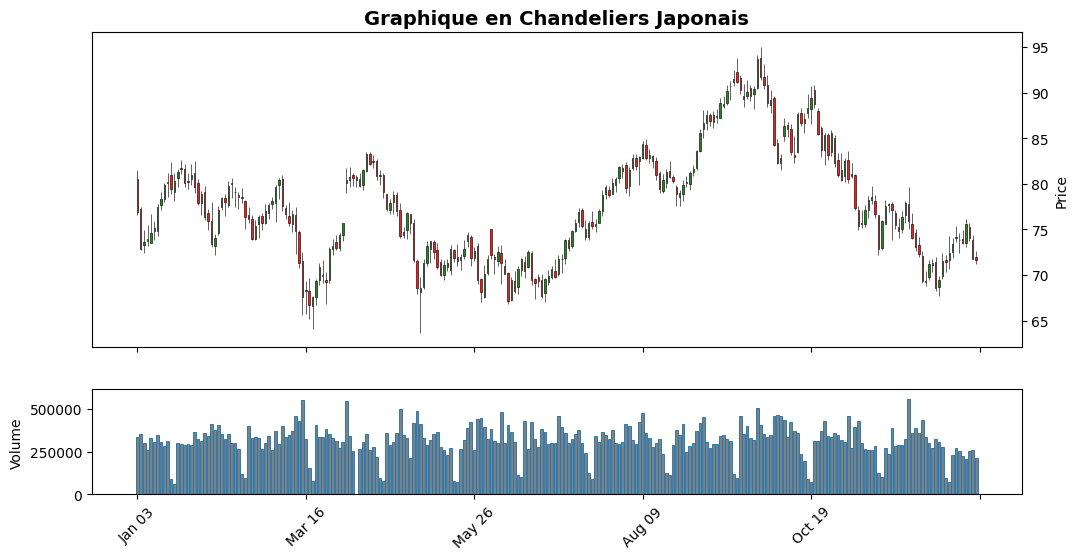

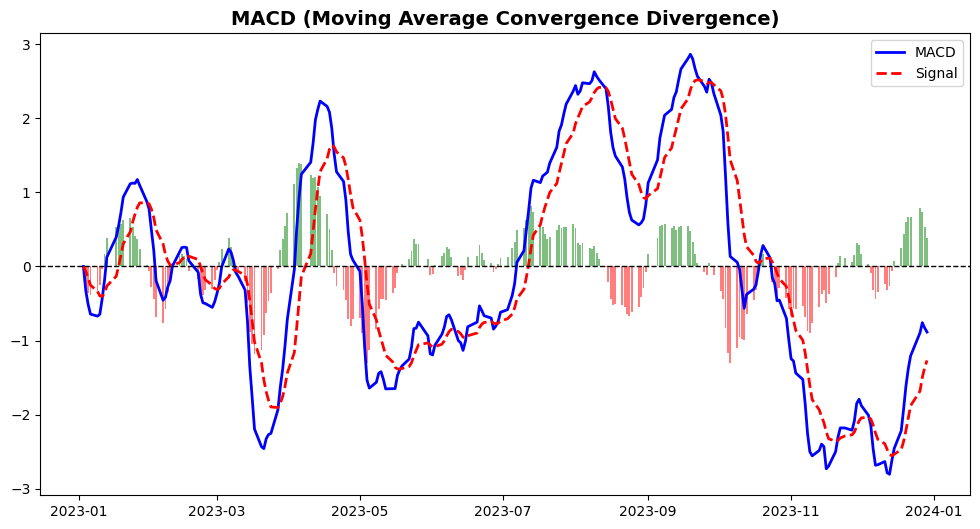

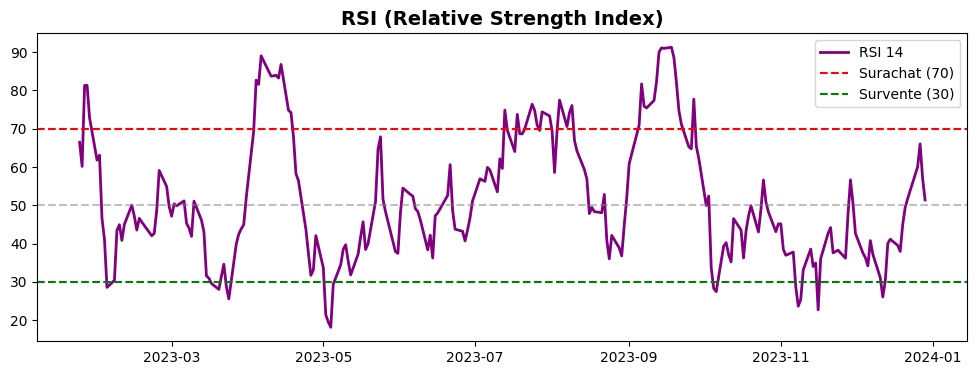

In [4]:
def plot_candlestick(data):
    """
    Affiche un graphique en chandelier avec un style moderne et épuré.
    """
    mc = mpf.make_marketcolors(up='green', down='red', wick='black', edge='black', volume='gray')
    s = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc)

    fig, (ax, ax_volume) = plt.subplots(2, figsize=(12, 6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    
    mpf.plot(data, type='candle', style=s, ax=ax, volume=ax_volume)
    
    ax.set_title("Graphique en Chandeliers Japonais", fontsize=14, fontweight='bold')
    
    plt.show()


def plot_macd(data, short_window=12, long_window=26, signal_window=9):
    """
    Affiche le MACD avec sa ligne de signal et son histogramme.
    """
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
 
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()

    histogram = macd - signal
 
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(data.index, macd, label="MACD", color='blue', linewidth=2)
    ax.plot(data.index, signal, label="Signal", color='red', linestyle='dashed', linewidth=2)
    ax.bar(data.index, histogram, color=np.where(histogram > 0, 'green', 'red'), alpha=0.5)
    
    ax.axhline(0, color='black', linewidth=1, linestyle='--')  # Ligne horizontale zéro
    ax.set_title("MACD (Moving Average Convergence Divergence)", fontsize=14, fontweight='bold')
    ax.legend()
    plt.show()

def plot_rsi(data, window=14):
    """
    Affiche le RSI (Relative Strength Index) avec une période donnée.
    """
    # Calcul du RSI
    delta = data['Close'].diff(1)
    gain = np.where(delta > 0, delta, 0) 
    loss = np.where(delta < 0, -delta, 0) 

    avg_gain = pd.Series(gain).rolling(window=window).mean()
    avg_loss = pd.Series(loss).rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(data.index, rsi, label=f'RSI {window}', color='purple', linewidth=2)
    ax.axhline(70, linestyle='dashed', color='red', label='Surachat (70)')
    ax.axhline(30, linestyle='dashed', color='green', label='Survente (30)')
    ax.axhline(50, linestyle='dashed', color='gray', alpha=0.5) 

    ax.set_title("RSI (Relative Strength Index)", fontsize=14, fontweight='bold')
    ax.legend()
    plt.show()

plot_candlestick(data)
plot_macd(data)
plot_rsi(data)


### Feature Engineering

In [5]:
def compute_rsi(series, period=14):
    """
    Calcule manuellement le RSI (Relative Strength Index).
    RSI = 100 - 100 / (1 + RS)
    RS = moyenne_pondérée_exponentielle(gains) / moyenne_pondérée_exponentielle(pertes)
    """
    delta = series.diff(1).dropna()
    gains = delta.where(delta > 0, 0.0)
    losses = -delta.where(delta < 0, 0.0)

    avg_gain = gains.ewm(com=period-1, min_periods=period).mean()
    avg_loss = losses.ewm(com=period-1, min_periods=period).mean()

    rs = avg_gain / (avg_loss + 1e-9)
    rsi = 100 - (100 / (1 + rs))
    # Ré-alignement
    rsi = rsi.reindex(series.index, method='bfill').fillna(method='bfill')
    return rsi

def compute_ema(series, period=12):
    """Calcule une EMA (Exponential Moving Average)."""
    return series.ewm(span=period, adjust=False).mean()


def compute_volatility(series, window=10):
    """ Calcule la volatilité (écart-type des prix de clôture sur une fenêtre). """
    return series.pct_change().rolling(window=window).std()

def compute_obv(data):
    """Calcule l'indicateur On-Balance Volume (OBV)."""
    obv = (np.sign(data["Close"].diff()) * data["Volume"]).fillna(0).cumsum()
    return obv

def compute_adi(data):
    """Calcule l'Accumulation/Distribution Index (ADI)."""
    money_flow_multiplier = ((data["Close"] - data["Low"]) - (data["High"] - data["Close"])) / \
                            (data["High"] - data["Low"])
    money_flow_volume = money_flow_multiplier * data["Volume"]
    adi = money_flow_volume.cumsum()
    return adi

data["Volatility"] = compute_volatility(data["Close"], window=10)
data["ADI"] = compute_adi(data)
data["OBV"] = compute_obv(data)
data["RSI"] = compute_rsi(data["Close"], period=14)
data["EMA12"] = compute_ema(data["Close"], period=12)
data.dropna(inplace=True)

C:\Users\mariu\AppData\Local\Temp\ipykernel_153028\2842522944.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rsi = rsi.reindex(series.index, method='bfill').fillna(method='bfill')


### Designing Environnement

In [ ]:
class Environment:
    """
    Environnement simplifié de trading.
    - Actions discrètes : 0=stay, 1=buy, 2=sell
    - On maintient une liste des positions ouvertes, on calcule le profit
      lorsque l'on vend (2), etc.
      
    Variables description:
    - self.df : DataFrame avec les données historiques
    - self.history_t : taille de la fenêtre historique
    - self.t : indice temporel actuel
    - self.done : booléen, True si la simulation est terminée
    - self.profits : gains cumulés
    - self.positions : liste des positions ouvertes (prix d'achat pas encore clôturé)
    - self.position_value : valeur actuelle des positions ouvertes (latent)
    - self.history : liste des variations de prix sur les derniers jours
    """

    def __init__(self, df, history_t=30):
        """
        :param df: DataFrame avec colonnes ['Open','High','Low','Close','RSI','EMA12'] par exemple
        :param history_t: taille de la fenêtre historique
        """
        self.df = df.copy().reset_index(drop=True)
        self.history_t = history_t
        self.features = ["Close", "RSI", "EMA12", "Volatility"] 
        self.reset()

    def reset(self):
        """
        Remet l'environnement à zéro :
         - t = 0
         - profits = 0
         - positions = []
         - position_value = 0
         - history -> [0]*history_t
        """
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0.0] * self.history_t

        return self._get_obs()

    def _get_obs(self):
        """
        Construit l'observation : 
        [position_value, price_diff_history..., Close(t), RSI(t), EMA12(t), Volatility(t)]
        """
        row = self.df.iloc[self.t]
        feats = []
        for col in self.features:
            feats.append(float(row[col]) if not pd.isnull(row[col]) else 0.0)

        obs = [self.position_value] + self.history + feats
        return np.array(obs, dtype=np.float32)
    
    def step(self, act):
        """
        Exécute l'action (0=stay,1=buy,2=sell).
        Retourne : obs, reward, done
        """
        reward = 0.0
        transaction_cost = 0.001  # Frais de transaction de 0.1%

        if act == 1:  # Achat
            buy_price = self.df.iloc[self.t]["Close"] * (1 + transaction_cost)
            self.positions.append(buy_price)

        elif act == 2:  # Vente
            if len(self.positions) == 0:
                reward = -2 
            else:
                profits = 0.0
                current_price = self.df.iloc[self.t]["Close"] * (1 - transaction_cost)
                for p in self.positions:
                    profit = current_price - p
                    profits += profit
                
                # Normalisation du profit
                avg_buy_price = np.mean(self.positions) if self.positions else 1.0
                reward = profits / (avg_buy_price + 1e-6)  # Évite division par 0
                
                # Ajustement par la volatilité
                volatility = self.df.iloc[self.t]["Volatility"] if "Volatility" in self.df.columns else 1.0
                reward = reward / (volatility + 1e-6)  # Évite les trop grands écarts
                
                # Clip des rewards pour éviter les pics extrêmes
                reward = np.clip(reward, -2.0, 2.0)

                # Mise à jour des profits cumulés
                self.profits += profits
                self.positions = []  # On ferme toutes les positions

        # Avancer le temps
        self.t += 1
        if self.t >= len(self.df) - 1:
            self.done = True

        # Calcul de la position latente
        self.position_value = 0.0
        if len(self.positions) > 0:
            current_price = self.df.iloc[self.t]["Close"]
            for p in self.positions:
                self.position_value += (current_price - p)

        # Mettre à jour l'historique
        if self.t > 0:
            price_diff = self.df.iloc[self.t]["Close"] - self.df.iloc[self.t - 1]["Close"]
        else:
            price_diff = 0.0
        self.history.pop(0)
        self.history.append(price_diff)

        return self._get_obs(), reward, self.done
    
    def step_v2(self, act):
        """
        Exécute l'action (0=stay,1=buy,2=sell).
        Retourne : obs, reward, done
        """
        reward = 0.0
        transaction_cost = 0.005  # Augmentation du coût à 0.5%
        
        # Vérifier la tendance du marché avec EMA50
        trend_filter = self.df.iloc[self.t]["Close"] > self.df.iloc[self.t]["EMA50"]

        if act == 1:  # Achat
            if trend_filter:  # Acheter seulement si tendance haussière
                buy_price = self.df.iloc[self.t]["Close"] * (1 + transaction_cost)
                self.positions.append((buy_price, self.t))  # Stocke prix + temps d'achat
            else:
                reward -= 0.1  # Pénalité si achat contre la tendance

        elif act == 2:  # Vente
            if len(self.positions) == 0:
                reward = -0.5  # Vente sans position, pénalité modérée
            else:
                profits = 0.0
                current_price = self.df.iloc[self.t]["Close"] * (1 - transaction_cost)
                total_holding_time = 0  # Pour encourager la conservation longue

                for p, entry_t in self.positions:
                    profit = current_price - p
                    profits += profit
                    holding_time = self.t - entry_t
                    total_holding_time += holding_time

                # Normalisation du profit
                avg_buy_price = np.mean([p for p, _ in self.positions]) if self.positions else 1.0
                reward = profits / (avg_buy_price + 1e-6)

                # Correction par la volatilité
                volatility = self.df.iloc[self.t]["Volatility"] if "Volatility" in self.df.columns else 1.0
                reward = reward / (volatility + 1e-6)

                # Encourager la conservation longue
                avg_holding_time = total_holding_time / len(self.positions) if self.positions else 1
                reward += 0.01 * avg_holding_time  # Plus un trade est conservé, plus le reward augmente

                # Clip des rewards
                reward = np.clip(reward, -1.0, 1.0)

                # Mise à jour des profits cumulés
                self.profits += profits
                self.positions = []  # On ferme toutes les positions

        # Pénaliser les transactions excessives
        reward -= 0.01 * len(self.positions)  # Réduit les trades inutiles

        # Avancer le temps
        self.t += 1
        if self.t >= len(self.df) - 1:
            self.done = True

        # Calcul de la position latente
        self.position_value = 0.0
        if len(self.positions) > 0:
            current_price = self.df.iloc[self.t]["Close"]
            for p, _ in self.positions:
                self.position_value += (current_price - p)

        # Mettre à jour l'historique
        if self.t > 0:
            price_diff = self.df.iloc[self.t]["Close"] - self.df.iloc[self.t - 1]["Close"]
        else:
            price_diff = 0.0
        self.history.pop(0)
        self.history.append(price_diff)

        return self._get_obs(), reward, self.done



## QLearning trader

[*********************100%***********************]  1 of 1 completed
C:\Users\mariu\AppData\Local\Temp\ipykernel_153028\2842522944.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rsi = rsi.reindex(series.index, method='bfill').fillna(method='bfill')


Training:   0%|          | 0/2000 [00:00<?, ?epoch/s]

Epoch 5/2000 - TrainLoss: 183.6698, ValLoss: 1818.5929, TrainProfit: -838.65, ValProfit: 0.00, TrainReward: -22.51, ValReward: 0.00, Eps: 0.10
Epoch 10/2000 - TrainLoss: 133.6563, ValLoss: 510.5015, TrainProfit: -110.19, ValProfit: 3.42, TrainReward: -25.85, ValReward: -37.42, Eps: 0.10
Epoch 15/2000 - TrainLoss: 237.6113, ValLoss: 410.7608, TrainProfit: 453.44, ValProfit: 0.00, TrainReward: 4.00, ValReward: 0.00, Eps: 0.10
Epoch 20/2000 - TrainLoss: 170.0104, ValLoss: 412.2332, TrainProfit: 5480.40, ValProfit: 0.00, TrainReward: -12.00, ValReward: 0.00, Eps: 0.10
Epoch 25/2000 - TrainLoss: 128.8072, ValLoss: 432.6693, TrainProfit: 518.00, ValProfit: 0.00, TrainReward: -30.19, ValReward: 0.00, Eps: 0.10
Epoch 30/2000 - TrainLoss: 571.3966, ValLoss: 661.2525, TrainProfit: 265.98, ValProfit: -405.67, TrainReward: -5.48, ValReward: -34.91, Eps: 0.10
Epoch 35/2000 - TrainLoss: 53.0654, ValLoss: 142.7209, TrainProfit: 671.42, ValProfit: 0.00, TrainReward: -20.39, ValReward: 0.00, Eps: 0.10


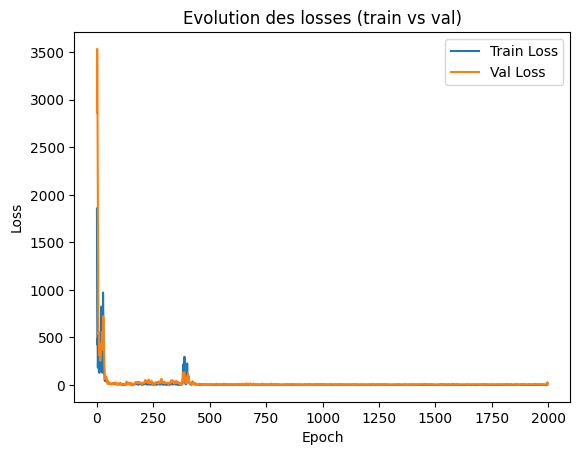

Reward total sur données test : 10.343647526861915
Actions prises : [0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 1, 2, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 1, 1, 0, 1, 1, 1]
Profit final : 507.8775415039104


C:\Users\mariu\AppData\Local\Temp\ipykernel_153028\3794485001.py:255: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.policy_net.load_state_dict(torch.load(best_model_pa

In [ ]:
class QNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class QLearningTrader:
    """
    Met en place un DQN simple en PyTorch pour entraîner un agent
    sur l'environnement de trading.
    """

    def __init__(
        self,
        env: Environment,
        input_dim,
        hidden_dim=64,
        output_dim=3,  # 0=stay,1=buy,2=sell
        gamma=0.95,
        lr=1e-3,
        memory_size=200,
        batch_size=32,
        eps_start=1.0,
        eps_min=0.01,
        update_target_freq=50,
        train_freq=10,
        eps_decay=0.995,  
        eps_reset_interval=500  
    ):
        self.env = env
        self.gamma = gamma
        self.lr = lr
        self.memory_size = memory_size
        self.batch_size = batch_size
        
        self.eps_decay = eps_decay
        self.eps_reset_interval = eps_reset_interval

        self.eps = eps_start
        self.eps_min = eps_min
        self.eps_decay = eps_decay
        self.update_target_freq = update_target_freq
        self.train_freq = train_freq

        # Réseaux
        self.policy_net = QNetwork(input_dim, hidden_dim, output_dim)
        self.target_net = copy.deepcopy(self.policy_net)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)

        # Mémoire de replay : [(pobs, act, reward, obs, done), ...]
        self.memory = []
        self.total_steps = 0

    def select_action(self, obs):
        """
        Sélection d'action via epsilon-greedy.
        """
        if random.random() < self.eps:
            return random.randint(0, 2)  # 3 actions: 0, 1, 2
        obs_t = torch.FloatTensor(obs).unsqueeze(0)
        with torch.no_grad():
            q_vals = self.policy_net(obs_t)
        return q_vals.argmax(dim=1).item()

    def update_epsilon(self):
        """
        Applique une décroissance exponentielle sur epsilon.
        """
        self.eps = max(self.eps_min, self.eps * self.eps_decay)
        
        # Réinitialisation périodique pour maintenir l'exploration
        if self.total_steps % self.eps_reset_interval == 0:
            self.eps = 1.0

    def store_transition(self, pobs, act, reward, obs, done):
        """
        Stocke la transition dans le buffer.
        """
        self.memory.append((pobs, act, reward, obs, done))
        if len(self.memory) > self.memory_size:
            self.memory.pop(0)

    def update_target(self):
        """
        Copie policy_net -> target_net
        """
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def train_step(self):
        """
        Un pas d'entraînement : on échantillonne un batch, on calcule la loss,
        et on met à jour policy_net.
        """
        if len(self.memory) < self.batch_size:
            return 0.0

        batch = random.sample(self.memory, self.batch_size)
        pobs, acts, rewards, obs_, dones = zip(*batch)
        pobs_t = torch.FloatTensor(pobs)
        acts_t = torch.LongTensor(acts)
        rewards_t = torch.FloatTensor(rewards)
        obs_t = torch.FloatTensor(obs_)
        dones_t = torch.BoolTensor(dones)

        # Q(s, a) du réseau policy_net
        q_vals = self.policy_net(pobs_t)
        # On ne prend que la Q-valeur de l'action réelle
        q_val = q_vals.gather(1, acts_t.unsqueeze(1)).squeeze(1)

        # Q-target : r + gamma * max(Q') (avec target_net)
        with torch.no_grad():
            q_next = self.target_net(obs_t)
            q_next_max, _ = q_next.max(dim=1)
            q_target = rewards_t + (self.gamma * q_next_max * (~dones_t))

        loss = nn.MSELoss()(q_val, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

def train_dqn(agent: QLearningTrader, env: Environment, env_val: Environment, epochs=100, best_model_path="best_model.pth"):
    """
    Entraîne l'agent sur l'environnement `env` et évalue la performance sur `env_val`.
    - Sauvegarde le meilleur modèle selon la loss de validation.
    - Affiche une barre de progression avec tqdm.
    """

    # Stockage pour affichage / plot
    train_losses, val_losses = [], []
    train_rewards, val_rewards = [], []
    train_profits, val_profits = [], []

    best_val_loss = float("inf")

    step_max = len(env.df) - 1

    for epoch in tqdm(range(1, epochs + 1), desc="Training", unit="epoch"):
        # --- TRAIN ---
        obs = env.reset()
        done = False
        ep_loss = 0.0
        ep_reward = 0.0
        while not done and env.t < step_max:
            action = agent.select_action(obs)
            next_obs, reward, done = env.step(action)

            agent.store_transition(obs, action, reward, next_obs, done)

            if agent.total_steps % agent.train_freq == 0:
                loss_val = agent.train_step()
                ep_loss += loss_val

            if agent.total_steps % agent.update_target_freq == 0:
                agent.update_target()

            agent.update_epsilon()

            obs = next_obs
            ep_reward += reward
            agent.total_steps += 1

        # On stocke la loss / reward sur cet epoch
        train_losses.append(ep_loss)
        train_rewards.append(ep_reward)
        train_profits.append(env.profits)

        # --- VALIDATION ---
        val_loss, val_reward, val_profit = evaluate(agent, env_val)
        val_losses.append(val_loss)
        val_rewards.append(val_reward)
        val_profits.append(val_profit)

        # Si la loss de validation s'améliore, on sauvegarde
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(agent.policy_net.state_dict(), best_model_path)

        # Affichage tous les 5 epochs (peut être ajusté)
        if epoch % 5 == 0:
            print(f"Epoch {epoch}/{epochs} - "
                  f"TrainLoss: {ep_loss:.4f}, ValLoss: {val_loss:.4f}, "
                  f"TrainProfit: {env.profits:.2f}, ValProfit: {val_profit:.2f}, "
                  f"TrainReward: {ep_reward:.2f}, ValReward: {val_reward:.2f}, "
                  f"Eps: {agent.eps:.2f}")

    return train_losses, val_losses, train_rewards, val_rewards, train_profits, val_profits


def evaluate(agent: QLearningTrader, env_val: Environment):
    """
    Evalue l'agent sur `env_val` en mode validation.
    Retourne la loss, le reward total et le profit final.
    """
    # On clone le policy_net pour ne pas impacter le training
    policy_net_backup = copy.deepcopy(agent.policy_net.state_dict())
    eps_backup = agent.eps

    agent.eps = 0.0  # Pas d'exploration en validation

    obs = env_val.reset()
    done = False
    step_max = len(env_val.df) - 1
    val_loss = 0.0
    val_reward = 0.0

    while not done and env_val.t < step_max:
        action = agent.select_action(obs)
        next_obs, reward, done = env_val.step(action)

        # Calcul d'une perte indicative (ici, MSE entre Qval et reward direct)
        # Ce n'est pas forcément la meilleure façon de calculer la loss de val, c'est un simple indicateur.
        q_vals = agent.policy_net(torch.FloatTensor(obs).unsqueeze(0))
        # Approx : val_loss += (reward - q_vals.max().item())**2
        # Ou on pourrait faire: (Q(action) - reward)**2
        # On prend la Q-value correspondant à l'action sélectionnée
        q_val_for_action = q_vals[0, action].item()
        val_loss += float((reward - q_val_for_action)**2)

        obs = next_obs
        val_reward += reward

    # On restaure le state_dict (optionnel, si on veut être sûr de ne pas modifier le policy)
    agent.policy_net.load_state_dict(policy_net_backup)
    agent.eps = eps_backup

    # Moyenne sur le nombre de steps
    num_steps_val = env_val.t
    val_loss = val_loss / num_steps_val if num_steps_val != 0 else val_loss
    val_profit = env_val.profits

    return val_loss, val_reward, val_profit


def test(agent: QLearningTrader, env_test: Environment, best_model_path="best_model.pth"):
    """
    Teste l'agent sur l'environnement `env_test`.
    Charge le meilleur modèle sauvegardé. Retourne le profit total et la liste d'actions.
    """
    # Charger le meilleur modèle
    agent.policy_net.load_state_dict(torch.load(best_model_path))
    agent.eps = 0.0  # pas d'exploration

    obs = env_test.reset()
    done = False
    total_profit = 0
    actions_taken = []

    step_max = len(env_test.df) - 1
    while not done and env_test.t < step_max:
        action = agent.select_action(obs)
        obs, reward, done = env_test.step(action)
        total_profit += reward
        actions_taken.append(action)

    print(f"Reward total sur données test : {total_profit}")
    print(f"Actions prises : {actions_taken}")
    print(f"Profit final : {env_test.profits}")
    return total_profit, actions_taken

if __name__ == "__main__":
    # Exemple d'utilisation (à adapter avec tes propres données)

    # 1) Récupération / prétraitement données
    ticker = "GC=F"  # exemple : Gold
    start = "2023-01-01"
    end = "2024-01-01"
    interval = "1d"
    data = yf.download(ticker, start=start, end=end, interval=interval)
    data.columns = data.columns.droplevel(1)

    data["Volatility"] = compute_volatility(data["Close"], window=10)
    data["ADI"] = compute_adi(data)
    data["OBV"] = compute_obv(data)
    data["RSI"] = compute_rsi(data["Close"], period=14)
    data["EMA12"] = compute_ema(data["Close"], period=12)
    data.dropna(inplace=True)

    # Séparation Train / Val / Test
    date_train = "2023-08-01"
    date_val = "2023-10-01"
    data_train = data.loc[:date_train]
    data_val = data.loc[date_train:date_val]
    data_test = data.loc[date_val:]

    # 2) Création des environnements
    env_train = Environment(data_train, history_t=30)
    env_val = Environment(data_val, history_t=30)
    env_test = Environment(data_test, history_t=30)

    sample_obs = env_train.reset()
    input_dim = len(sample_obs)

    # 3) Instanciation de l'agent
    trader = QLearningTrader(
        env_train,
        input_dim=input_dim,
        hidden_dim=64,
        output_dim=3,
        gamma=0.95,
        lr=1e-3,
        memory_size=500,
        batch_size=32,
        eps_start=1.0,
        eps_min=0.01,
        eps_decay=0.995,
        update_target_freq=50,
        train_freq=10
    )

    # 4) Entraînement
    epochs = 2000
    best_model_path = "best_model.pth"
    (train_losses, val_losses,
     train_rewards, val_rewards,
     train_profits, val_profits) = train_dqn(trader, env_train, env_val, epochs=epochs, best_model_path=best_model_path)

    print("=== Entraînement terminé ===")

    # 5) Courbes de loss (train/val) sur toutes les époques
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Evolution des losses (train vs val)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # 6) Test sur ensemble non vu
    test_profit, actions_taken = test(trader, env_test, best_model_path=best_model_path)

In [ ]:
ticker = "GC=F"  # exemple : Gold
start = "2022-01-01"
end = "2024-01-01"
interval = "1d"
data = yf.download(ticker, start=start, end=end, interval=interval)
data.columns = data.columns.droplevel(1)

data["Volatility"] = compute_volatility(data["Close"], window=10)
data["ADI"] = compute_adi(data)
data["OBV"] = compute_obv(data)
data["RSI"] = compute_rsi(data["Close"], period=14)
data["EMA12"] = compute_ema(data["Close"], period=12)
data.dropna(inplace=True)

# Ici, insérer tes features (RSI, EMA, Volatility etc.) si besoin
# Suppose qu'on a déjà calculé data['RSI'], data['EMA12'], data['Volatility'] etc.
# ...
# Ex: data.dropna(inplace=True)

# Séparation Train / Val / Test
date_train = "2023-03-01"
date_val = "2023-07-01"
data_train = data.loc[:date_train]
data_val = data.loc[date_train:date_val]
data_test = data.loc[date_val:]

# 2) Création des environnements
env_train = Environment(data_train, history_t=30)
env_val = Environment(data_val, history_t=30)
env_test = Environment(data_test, history_t=30)

sample_obs = env_train.reset()
input_dim = len(sample_obs)

test_profit, actions_taken = test(trader, env_test, best_model_path=best_model_path)

[*********************100%***********************]  1 of 1 completed

Reward total sur données test : 26.951610821836425
Actions prises : [0, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 0, 1, 0, 1, 0, 2, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 2, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 1, 1, 0, 1, 1, 1]
Profit final : 2166.7422766113446



C:\Users\mariu\AppData\Local\Temp\ipykernel_153028\2842522944.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rsi = rsi.reindex(series.index, method='bfill').fillna(method='bfill')
C:\Users\mariu\AppData\Local\Temp\ipykernel_153028\3794485001.py:255: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe

C:\Users\mariu\AppData\Local\Temp\ipykernel_153028\975831658.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.policy_net.load_state_dict(torch.load(best_model_path

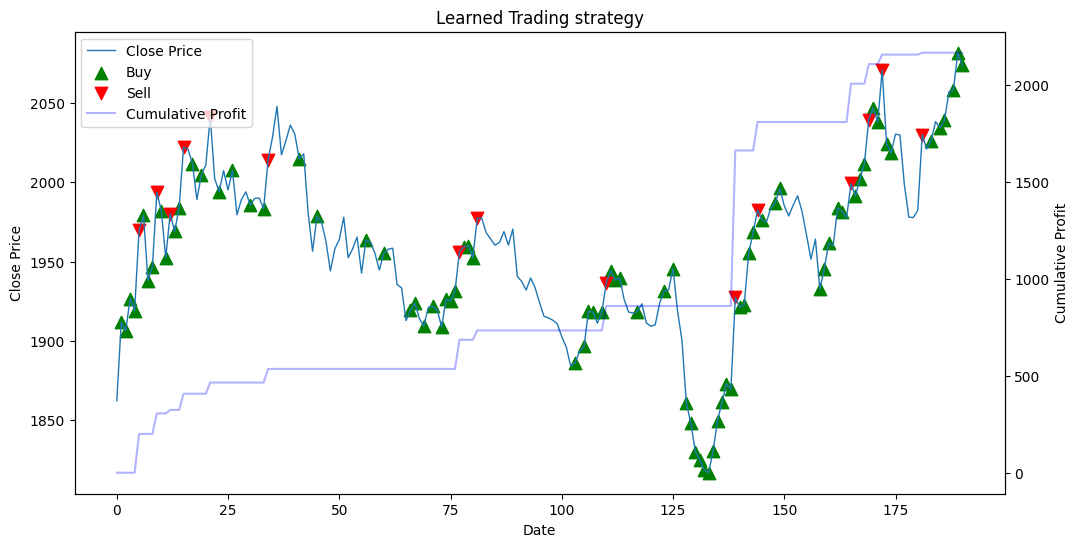

In [20]:
import torch
import matplotlib.pyplot as plt

def visualize_trading_strategy(agent, env, best_model_path="best_model.pth"):
    """
    Visualise la stratégie de trading apprise en rejouant l'environnement
    avec le meilleur modèle sauvegardé.
    - agent: instance de QLearningTrader
    - env: instance de Environment
    - best_model_path: chemin vers le modèle PyTorch (fichier .pth)
    """

    # 1) Charger le meilleur modèle et désactiver l'exploration
    agent.policy_net.load_state_dict(torch.load(best_model_path))
    agent.eps = 0.0

    # 2) Remettre l'env à zéro
    obs = env.reset()
    done = False
    step_max = len(env.df) - 1

    # 3) Variables pour stocker l'historique
    close_prices = []
    actions = []
    profits_over_time = []

    # 4) Boucle sur l'environnement
    while not done and env.t < step_max:
        current_close = env.df.iloc[env.t]["Close"]
        close_prices.append(current_close)

        # Sélection de l'action et step
        action = agent.select_action(obs)
        actions.append(action)

        obs, reward, done = env.step(action)
        profits_over_time.append(env.profits)

    # Attention : il est possible que la dernière étape ajoute un close supplémentaire
    # selon ta logique ; on s'assure que tout s'aligne bien.
    # On récupère l'index sur la portion réellement simulée :
    simulation_index = env.df.index[:len(close_prices)]

    # 5) Identifiers de Buy / Sell / Stay
    buy_indices = [i for i, a in enumerate(actions) if a == 1]
    sell_indices = [i for i, a in enumerate(actions) if a == 2]

    # 6) Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(simulation_index, close_prices, label='Close Price', linewidth=1)

    # Positions d'achat (vert, flèche haut) & de vente (rouge, flèche bas)
    ax.scatter(simulation_index[buy_indices],
               [close_prices[i] for i in buy_indices],
               marker="^", color="green", s=80, label="Buy")

    ax.scatter(simulation_index[sell_indices],
               [close_prices[i] for i in sell_indices],
               marker="v", color="red", s=80, label="Sell")

    ax.set_xlabel("Date")
    ax.set_ylabel("Close Price")

    # 7) Ajout d'un second axe pour le profit cumulé
    ax2 = ax.twinx()
    ax2.plot(simulation_index, profits_over_time, color="blue", alpha=0.3, label="Cumulative Profit")
    ax2.set_ylabel("Cumulative Profit")

    # Gestion des légendes
    lines_1, labels_1 = ax.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best')

    plt.title("Learned Trading strategy")
    plt.show()



visualize_trading_strategy(trader, env_test, best_model_path="best_model.pth")


In [ ]:
# TODO : Regarder le history et autres hyper para
# TODO : Augmenter le train
# TODO : Tendance sur laquelle on se trouve et evaluer une moyenne du profit sur toutes le tendances !!
# TODO : Faire de l'augmentation de données sur les actifs de l'or
# TODO : mettre un tqdm
# TODO : Graph CNN et spectogramme

# TODO : implémenter un agent plus complexe, avec un réseau plus profond, et des features plus avancées.
# TODO : optimiser les hyperparamètres (grid search, etc.)
# TODO : ajouter des features (volatilité, etc.)
# TODO : ajouter une manière d'acheter plusieurs action à la fois (quantité variable)
# TODO : ajouter des frais de transaction
# TODO : Augmenter la fréquence de trading (intraday) et de points
# TODO : ajouter un stop-loss sur les positions
# TODO : ajouter un take-profit
# TODO : ajouter un système de double Q-learning ou Multi agent DQN
# TODO : ajouter un système de priorité dans le replay buffer
# TODO : ajouter les graphiques de trade comme dans Kaggle
# TODO : ajouter un système de rendement annualisé
# TODO : ajouter un système de récompense plus complexe
# TODO : ajouter un système de logging (TensorBoard, etc.)
# TODO : ajouter une sauvegarde du modèle
# TODO : ajouter un système de validation (early stopping)
# TODO : ajouter un système de rendu vidéo (Gym)
# TODO : essayer sur d'autres actifs (forex, crypto, etc.)
# TODO : essayer sur d'autres environnements (Gym)
# TODO : essayer d'autres algorithmes (PPO, DDPG, etc.)
# TODO : essayer d'autres techniques de deep learning (LSTM, etc.)
# TODO : essayer d'autres techniques de reinforcement learning (DQN, etc.)
# TODO : essayer d'autres techniques de trading (pairs trading, etc.)
# TODO : CNN dont la loss est f(xi) - somme des différences croissantes
# TODO : Rajouter le volume dans les features
# TODO : Rajouter des features de volatilité
# TODO : Rajouter des features de momentum
# TODO : Rajouter des features de tendance
# TODO : Rajouter des features de support et résistance
# TODO : Rajouter des features de gap
# TODO : Rajouter des features de chandeliers japonais
# TODO : Rajouter des features de pattern recognition
# TODO : Rajouter des features de news sentiment
# TODO : Rajouter des features de sentiment analysis
# TODO : Rajouter des features de macroéconomie
# TODO : Rajouter des features de microéconomie
# TODO : Rajouter des features de taux d'intérêt
# TODO : Rajouter des features de politique monétaire
# TODO : Faire un modèle qui continue d'apprendre au fur et a mesure pour s'adapter au marché